In [1]:
import os
import sys
import numpy as np
# import psycopg2
import sqlalchemy
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
from collections import defaultdict
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='paper',
    font_scale=8/8.8,
#     context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [2]:
import datashader as ds
from datashader.mpl_ext import dsshow
import datashader.transfer_functions as dstf

In [3]:
print(np.__version__)
print(pd.__version__)

1.22.3
1.4.2


In [4]:
import nfp
print(nfp.__version__)

2022-06-23 13:33:59.565698: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nopt/slurm/current/lib:
2022-06-23 13:33:59.565731: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


0.3.12


In [5]:
os.chdir('../')

In [6]:
print(os.getcwd())
sys.path.append('../../')
import rlmolecule
from rlmolecule.sql.run_config import RunConfig
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore
from rlmolecule.crystal.crystal_state import CrystalState

/home/jlaw/projects/arpa-e/crystals/rlmolecule/examples/crystal_energy


In [7]:
# connect to the db
config_file = "config/config_experiments.yaml"
run_config = RunConfig(config_file)
engine = run_config.start_engine()
Session.configure(bind=engine)
session = Session()

38 actions_to_ignore


In [8]:
def load_games_played(session, run_id):
#     print("Loading games")
    df = pd.read_sql(session.query(GameStore).filter_by(run_id=run_id).statement, session.bind)

    df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
    df = df.sort_values('time_hours')
    df_games = df
    df_games.reset_index(drop=True, inplace=True)
#     print(df_games.tail(3))
    return df_games


def load_rewards(session, run_id):
    print("Loading rewards")
    df = pd.read_sql(session.query(RewardStore).filter_by(run_id=run_id).statement, session.bind)
    # df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
    df = df.sort_values('reward', ascending=False)
    df_rew = df
    # print(df_rew.head(3))
    return df_rew


def load_states(session, run_id):
#     print("Loading rewards")
    df = pd.read_sql(session.query(StateStore).filter_by(run_id=run_id).statement, session.bind)
    return df

def get_state_for_rew(digest, df_state):
    return df_state[df_state['digest'] == digest]


# def write_best_crystals():
#     df_rew = load_rewards

In [9]:
def plot_reward(df, log, out_dir, title=""):
    fig, ax = plt.subplots(figsize=(3, 2.75), dpi=150)
    axs = [ax]
    axs[0].plot(df.time_hours, df.raw_reward, '.', ms=.75, label='games')
    axs[0].plot(df.time_hours, df.raw_reward.rolling(250, min_periods=50).quantile(.75), label='$r_{75}$')

    axs[0].legend(loc='upper right', ncol=2, borderpad=0, borderaxespad=0,
                bbox_to_anchor=(1.1, 1.2), markerscale=10)

    axs[0].set_yticks(np.arange(-5, 5, 2))
    axs[0].set_ylabel('Reward')

    plt.tight_layout()
    sns.despine(offset=5, trim=True)
    plt.title(title)

    out_file = f"{out_dir}/training.svg"
    print(out_file)
    os.makedirs(os.path.dirname(out_file), exist_ok=True)
    plt.savefig(out_file, bbox_inches="tight")
    plt.savefig(out_file.replace('.svg','.pdf'), bbox_inches="tight")
    plt.savefig(out_file.replace('.svg','.png'), bbox_inches="tight")
    plt.show()
    plt.close()

In [10]:
def plot_reward_train_curves(df, log, out_dir, title="", 
                             r_cutoff=0.75, r_rolling=250):
    fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(3, 2.75), dpi=150)
    # axs[0].plot(df.time_hours, df.raw_reward, '.', ms=.75, alpha=.2, label='rollouts')
    dsshow(df, ds.Point('time_hours', 'raw_reward'),
           ax=axs[0], shade_hook=dstf.dynspread, 
           cmap='Blues', norm='eq_hist', aspect='auto', 
           # y_range=yrange, x_range=xrange)
          )

    axs[0].plot(df.time_hours, df.raw_reward.rolling(r_rolling, min_periods=50).quantile(r_cutoff), 
                label=f'r_{int(r_cutoff * 100)}',
                color="C1",
               )

    axs[1].plot(log.time_hours, log.policy_wrapper_loss, label='value loss')
    axs[1].plot(log.time_hours, log.policy_wrapper_1_loss, label='prior loss')

    axs[0].legend(loc='upper right', ncol=2, borderpad=0, borderaxespad=0,
                bbox_to_anchor=(1.1, 1.2), markerscale=10)
    for lh in axs[0].get_legend().legendHandles:
        lh.set_alpha(1)
    axs[1].legend(
        loc='upper right', ncol=2,
        borderpad=0, borderaxespad=0.1,
        bbox_to_anchor=(1.1, 1.2))

    #axs[1].set_ylim([0, .7])
    #axs[1].set_xlim([-.01, 4])
    axs[0].set_yticks(np.arange(0, 1, 0.2))
    # axs[0].set_ylim(-0.02, 1.02)
    # axs[0].set_ylim(-3.1, 5.6)
    axs[1].set_yticks(np.arange(0, .7, .2))
    axs[1].set_ylim(0, .62)
    axs[0].set_ylabel('Reward')
    axs[1].set_ylabel('Policy Training')
    axs[1].set_xlabel('Time (hours)')

    plt.tight_layout()
    sns.despine(offset=5, trim=True)
    plt.suptitle(title, y=1.0)
    
    # plt.setp(axs[0].legend, alpha=1)

    out_file = f"{out_dir}/training-and-reward.svg"
    print(out_file)
    os.makedirs(os.path.dirname(out_file), exist_ok=True)
    plt.savefig(out_file, bbox_inches="tight")
#     plt.savefig(out_file.replace('.svg','.pdf'), bbox_inches="tight")
    plt.savefig(out_file.replace('.svg','.png'), bbox_inches="tight")
    plt.show()
    plt.close()

# Compare Experiment Results

In [11]:
exp_name = "crystal_energy"
run_id = run_config.run_id
print(run_id)

crystal_energy_example


In [12]:
log_dir = f"/projects/rlmolecule/jlaw/logs/{exp_name}"
def main_results(run_id, session, 
                 r_cutoff=0.75,
                 r_rolling=250,
                 limit_to_log=False):
    working_dir = f"{log_dir}/{run_id}"
    # load the games played
    df_games = load_games_played(session, run_id)
    df_games = df_games.dropna()
#     print(df_games.head(2))
    print(f"{len(df_games)} games loaded")

    log_file = f"{working_dir}/policy_checkpoints/log.csv"
    try:
        print(f"Reading {log_file}")
        log = pd.read_csv(log_file)
    except FileNotFoundError:
        print(f"log.csv not found for {run_id}")
        return
    log['time'] = pd.to_datetime(log.time)
    if limit_to_log:
        df_games = df_games[df_games.time >= log.time.min()]
        df_games['time_hours'] = (df_games.time - df_games.time.min()).apply(lambda x: x.total_seconds() / 3600)
    print(df_games.time.min())
    log['time_hours'] = (log.time - df_games.time.min()).apply(lambda x: x.total_seconds() / 3600)
#     print(log.tail(3))

        # df_games = df_games[df_games.time_hours >= log.time_hours]

    # now plot the results
    out_dir = f"{working_dir}/viz"
#     plot_reward(df_games, log, out_dir, title=run_id)
#     plot_reward_train_curves(df_games, log, out_dir, title=run_id)
    plot_reward_train_curves(df_games, log, out_dir, 
                             r_cutoff=r_cutoff,
                             r_rolling=r_rolling,
                            )

    return df_games
    # and write POSCAR files for the best structures
    # df_rew = load_rewards(session, run_id)
#     print(df_rew.head(2))
    # return df_games, df_rew

In [83]:
out_dir = "/projects/rlmolecule/jlaw/paper-archive/2022-rlcrystal"
df_games.to_csv(f"{out_dir}/{run_id}_games.csv.gz")
df_rew_predvol.to_csv(f"{out_dir}/{run_id}_rewards.csv.gz")

9669 games loaded
Reading /projects/rlmolecule/jlaw/logs/crystal_energy/20220623-batt-icsd-vol-no-states-seen-ele-repl-r90-no-ties-debug/policy_checkpoints/log.csv
2022-06-23 19:32:58.573889
/projects/rlmolecule/jlaw/logs/crystal_energy/20220623-batt-icsd-vol-no-states-seen-ele-repl-r90-no-ties-debug/viz/training-and-reward.svg


/home/jlaw/.conda-envs/crystals_nfp0_3/lib/python3.8/site-packages/datashader/mpl_ext.py:143: UserWarning: EqHistColorMapper warning: Histogram equalization did not converge.
  warnings.warn(
/home/jlaw/.conda-envs/crystals_nfp0_3/lib/python3.8/site-packages/datashader/mpl_ext.py:143: UserWarning: EqHistColorMapper warning: Histogram equalization did not converge.
  warnings.warn(


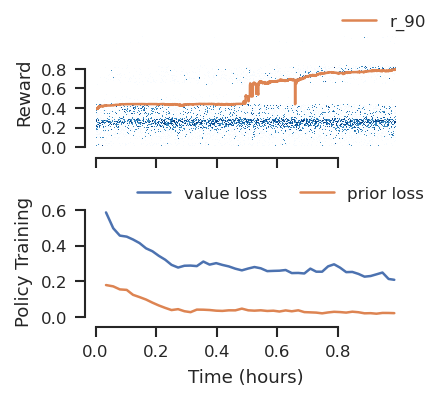

In [40]:
run_ids = [
    # "20220617-batt-icsd-vol-no-states-seen-debug",
           # "20220623-batt-icsd-vol-no-states-seen-debug",
           # "20220623-batt-icsd-vol-no-states-seen-ele-repl-debug",
           # "20220623-batt-icsd-vol-no-states-seen-ele-repl-r90-debug",
           # "20220623-batt-icsd-vol-no-states-seen-ele-repl-buff10000-debug",
           "20220623-batt-icsd-vol-no-states-seen-ele-repl-r90-no-ties-debug",
          ]
for run_id in run_ids:
    r_cutoff = 0.9 if 'r90' in run_id else .75
    df_games = main_results(run_id, session, r_cutoff=r_cutoff, r_rolling=500)

200360 games loaded
Reading /projects/rlmolecule/jlaw/logs/crystal_energy/20220623-batt-icsd-vol-no-states-seen-ele-repl-r90-no-ties-2/policy_checkpoints/log.csv
2022-06-23 22:03:00.463143
/projects/rlmolecule/jlaw/logs/crystal_energy/20220623-batt-icsd-vol-no-states-seen-ele-repl-r90-no-ties-2/viz/training-and-reward.svg


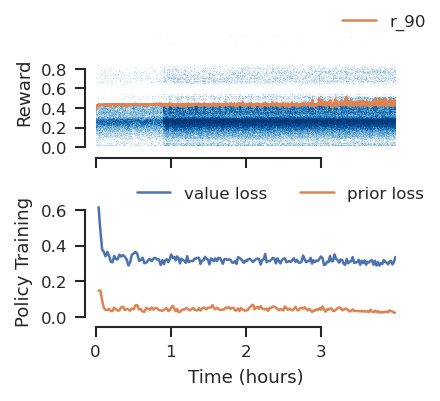

In [43]:
run_ids = [
           # "20220623-batt-icsd-vol-no-states-seen-ele-repl-r90-no-ties",
           "20220623-batt-icsd-vol-no-states-seen-ele-repl-r90-no-ties-2",
          ]
for run_id in run_ids:
    r_cutoff = 0.9 if 'r90' in run_id else .75
    df_games = main_results(run_id, session, r_cutoff=r_cutoff, r_rolling=500)

In [22]:
df_games.head(1)

,id,run_id,time,raw_reward,scaled_reward,search_statistics,execution_statistics,time_hours
0,49652153-2dbf-45f8-80b5-1432e0d647e7,20220623-batt-icsd-vol-no-states-seen-ele-repl...,2022-06-23 16:16:12.795417,0.337957,1.0,[[dac76aa20cce6ace32d9dc61ac6e1c7fe855a2664803...,"{'total_time': 5.128159046173096, 'execution_t...",0.0


<AxesSubplot:>

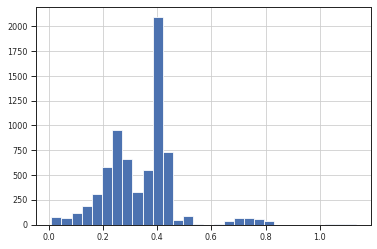

In [23]:
df_games.raw_reward.hist(bins=30)

<AxesSubplot:xlabel='time_hours', ylabel='raw_reward'>

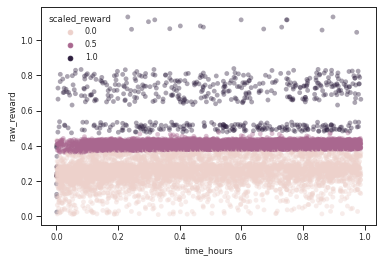

In [35]:
sns.scatterplot(data=df_games, x='time_hours', y='raw_reward', hue='scaled_reward', 
                linewidth=0, alpha=0.4)

182846 games loaded
Reading /projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-2/policy_checkpoints/log.csv
2022-06-18 11:28:36.439702
/projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-2/viz/training-and-reward.svg


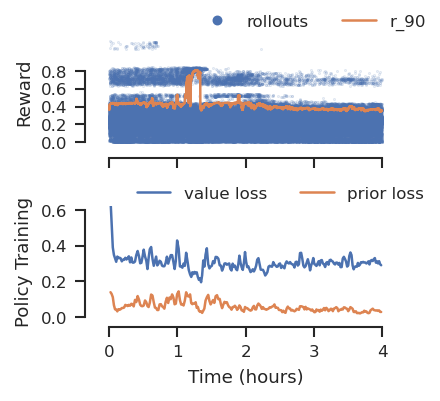

174980 games loaded
Reading /projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-no-cond-ion-2/policy_checkpoints/log.csv
2022-06-18 11:28:38.233276
/projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-no-cond-ion-2/viz/training-and-reward.svg


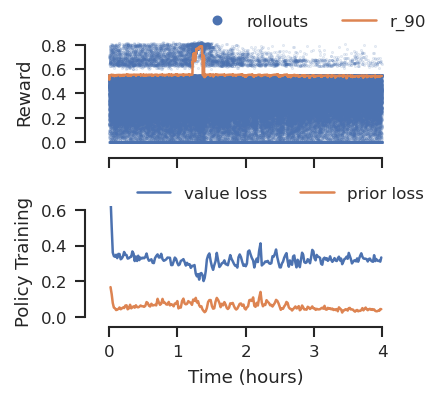

202574 games loaded
Reading /projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-no-halides-2/policy_checkpoints/log.csv
2022-06-18 11:28:31.975833
/projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-no-halides-2/viz/training-and-reward.svg


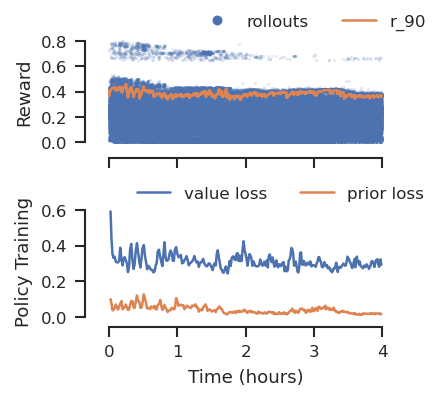

In [102]:
run_ids = ["20220617-batt-icsd-vol-r90-2",
           "20220617-batt-icsd-vol-r90-no-cond-ion-2",
           "20220617-batt-icsd-vol-r90-no-halides-2",
          ]
for run_id in run_ids:
    r_cutoff = 0.9 if 'r90' in run_id else .75
    r_rolling = 1000
    df_games = main_results(run_id, session, r_cutoff=r_cutoff, r_rolling=r_rolling)

In [155]:
def apply_rew_cutoff(df_rew, rew_cutoff=.6, decomp_energy_cutoff=None):
    # df_rew['time_hours'] = (df_rew.time - df_rew.time.min()).apply(lambda x: x.total_seconds() / 3600)
    df_rew['id'] = df_rew['data'].apply(lambda x: x['state_repr'])
    for col in df_rew.data.values[0]:
        df_rew[col] = df_rew.data.apply(lambda x: x[col] if col in x else None)

    print("here")
    df_top = df_rew[df_rew.reward > rew_cutoff]
    print(f"{df_top.id.nunique()} structures with reward > {rew_cutoff}")
    print(f"{len(df_rew[df_rew.decomp_energy < -0.1])} structures with decomp_energy < -0.1")
    if decomp_energy_cutoff is not None:
        df_top = df_rew[df_rew.decomp_energy < decomp_energy_cutoff]
        print(f"{df_top.id.nunique()} structures with decomp_energy < {decomp_energy_cutoff}")
    return df_top


def plot_subrewards(df_top, out_dir=None):
    df_top['comp'] = df_top.id.apply(lambda x: x.split("|")[0])
    best_strc_per_comp = df_top[['comp', 'id', 'reward']].groupby('comp').max()
    print(f"subset to {len(best_strc_per_comp)} best structure per composition (out of {df_top.id.nunique()}")
    df_top = df_top[df_top.id.isin(best_strc_per_comp.id)]
    
    rew_cols = ['decomp_energy', "cond_ion_frac", "reduction", "oxidation", "stability_window"]
    df_top['sub_rewards'] = df_top.apply(lambda row: {c: row[c] for c in rew_cols}, axis=1)

    rew_combiner = crystal_reward.StructureRewardBattInterface(None)
    # rew_combiner.reward_ranges.update({"decomp_energy": (-2, 5)})
    df_top['scaled_rew'] = df_top.sub_rewards.apply(
        lambda x: rew_combiner.combine_rewards(x, return_weighted=True))
    for col in rew_cols:
        df_top.loc[:, col+'_scaled'] = df_top.scaled_rew.apply(lambda x: x[col])
    scaled_cols = [col+'_scaled' for col in rew_cols]
    # also keep track of which structures passed all cutoffs
    df_top['scaled_rew_sum'] = df_top[scaled_cols].sum(axis=1)
    df_top['passed_all_cutoffs'] = df_top.reward - df_top.scaled_rew_sum

    # df_top2 = pd.concat([df_top[df_top.reward > df_top.reward.quantile(.95)], 
    #                  df_top[df_top.reward <= df_top.reward.quantile(.95)].sample(3000)])
    # print(f"subset from {len(df_top)} to {len(df_top2)} rows")
    # df_rew_scaled_orig = df_top[[c+'_scaled' for c in rew_cols] + ['id']].set_index('id')
    df_rew_scaled = df_top[scaled_cols + ['passed_all_cutoffs', 'id']].set_index('id')
    df_rew_scaled.sum(axis=1).hist(bins=30)
    plt.show()
    plt.close()
    
    f, ax = plt.subplots(figsize=(8,4))
    
    ax = df_rew_scaled.plot(kind='bar', stacked=True, 
                            width=1.0, linewidth=0, 
                            ax=ax)
    ax.set_xticks([])
    plt.show()
    plt.close()

    if out_dir is not None:
        weighted_cols = [c.replace('_scaled', '_s_w') for c in scaled_cols]
        df_top = df_top.rename(columns={c: c.replace('_scaled', '_s_w') for c in scaled_cols})
        df_top = df_top[['id', 'comp', 'reward'] + rew_cols + weighted_cols]

        os.makedirs(out_dir, exist_ok=True)
        out_file = f"{out_dir}/best_strc_per_comp_rewards.csv"
        print(out_file)
        df_top.to_csv(out_file, index=False)
    
    return df_top, df_rew_scaled


182846 games loaded
Reading /projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-2/policy_checkpoints/log.csv
2022-06-18 11:28:36.439702
/projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-2/viz/training-and-reward.svg


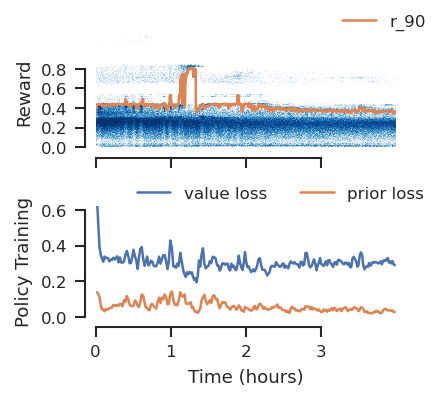

174980 games loaded
Reading /projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-no-cond-ion-2/policy_checkpoints/log.csv
2022-06-18 11:28:38.233276
/projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-no-cond-ion-2/viz/training-and-reward.svg


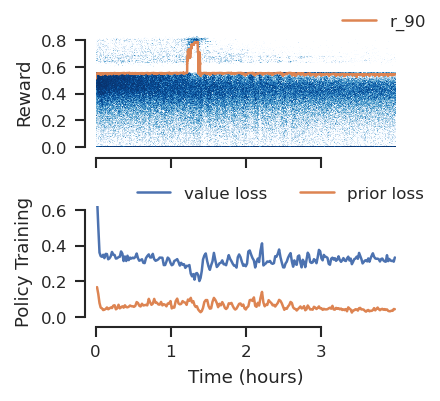

202574 games loaded
Reading /projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-no-halides-2/policy_checkpoints/log.csv
2022-06-18 11:28:31.975833
/projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-no-halides-2/viz/training-and-reward.svg


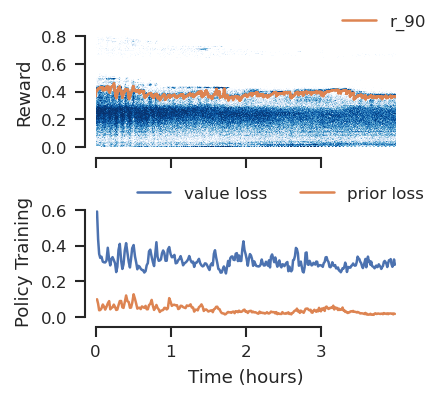

In [210]:
run_ids = ["20220617-batt-icsd-vol-r90-2",
           "20220617-batt-icsd-vol-r90-no-cond-ion-2",
           "20220617-batt-icsd-vol-r90-no-halides-2",
          ]
for run_id in run_ids:
    r_cutoff = 0.9 if 'r90' in run_id else .75
    r_rolling = 1000
    df_games = main_results(run_id, session, r_cutoff=r_cutoff, r_rolling=r_rolling)

<AxesSubplot:>

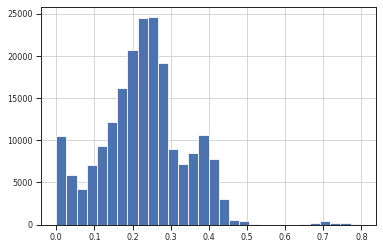

In [212]:
df_games.raw_reward.hist(bins=30)

subset to 1163 best structure per composition (out of 30924


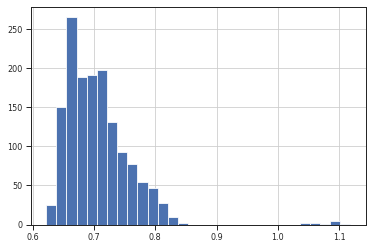

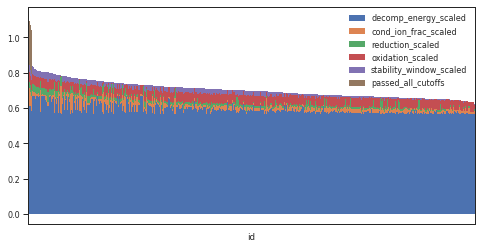

/projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-no-halides-2/viz/best_strc_per_comp_rewards.csv


In [156]:
run_id = "20220617-batt-icsd-vol-r90-2"
df_rew = load_rewards(session, run_id)
df_top = apply_rew_cutoff(df_rew, rew_cutoff=.6, decomp_energy_cutoff=None)
# df_top2, df_rew_scaled = plot_subrewards(df_top, out_dir=f"{log_dir}/{run_id}/viz")
df_top2, df_rew_scaled = plot_subrewards(df_top)

In [153]:
df_top2.head()

,digest,hash,run_id,time,reward,data,time_hours,id,terminal,num_sites,...,sub_rewards,scaled_rew,decomp_energy_scaled,cond_ion_frac_scaled,reduction_scaled,oxidation_scaled,stability_window_scaled,comp,scaled_rew_sum,passed_all_cutoffs
979859,d4d8ada837dba20868c1dec663a1c0843e00fcc79e8bd0...,2131766609857592968,20220617-batt-icsd-vol-r90-2,2022-06-18 12:06:14.448627,1.118399,"{'terminal': True, 'num_sites': 20, 'volume': ...",0.627614,Li3Sc1Br6|_1_3_6|trigonal|icsd_401335|1,True,20.0,...,"{'decomp_energy': -0.7607, 'cond_ion_frac': 0....","{'decomp_energy': 0.6400777777777777, 'cond_io...",0.640078,0.083333,0.044719,0.055556,0.044719,Li3Sc1Br6,0.868404,0.249995
736942,ba14132db5a6d85c545975e09b22bdee21ebfd3cc30a49...,8273700422910112632,20220617-batt-icsd-vol-r90-2,2022-06-18 11:57:15.346040,1.093755,"{'terminal': True, 'num_sites': 20, 'volume': ...",0.477863,Na3Sc1I6|_1_3_6|trigonal|icsd_401335|1,True,20.0,...,"{'decomp_energy': -0.5759, 'cond_ion_frac': 0....","{'decomp_energy': 0.6195444444444445, 'cond_io...",0.619544,0.083333,0.045378,0.052839,0.042660,Na3Sc1I6,0.843754,0.250001
767546,e49b9d66078d4055ed15a0d17877734fc4ba7356566ec6...,8273700422910112632,20220617-batt-icsd-vol-r90-2,2022-06-18 11:58:19.345149,1.093755,"{'terminal': True, 'num_sites': 20, 'volume': ...",0.495641,Na3Sc1I6|_1_3_6|trigonal|icsd_401335|1,True,20.0,...,"{'decomp_energy': -0.5759, 'cond_ion_frac': 0....","{'decomp_energy': 0.6195444444444445, 'cond_io...",0.619544,0.083333,0.045378,0.052839,0.042660,Na3Sc1I6,0.843754,0.250001
13618,5188352fc1107caf0668a0ba2f6492af57049175de411c...,4617266788384062941,20220617-batt-icsd-vol-r90-2,2022-06-18 11:29:09.921178,1.093518,"{'terminal': True, 'num_sites': 28, 'volume': ...",0.009690,K5Y1Br8|_1_5_8|triclinic|icsd_262807|1,True,28.0,...,"{'decomp_energy': -0.5104, 'cond_ion_frac': 0....","{'decomp_energy': 0.6122666666666666, 'cond_io...",0.612267,0.099194,0.038246,0.055556,0.038246,K5Y1Br8,0.843508,0.250011
90592,db92bb899a9d1b694af2cfd92e7e005bc5b5a5ebfa2f4e...,9095003521896262958,20220617-batt-icsd-vol-r90-2,2022-06-18 11:31:57.483973,1.088508,"{'terminal': True, 'num_sites': 28, 'volume': ...",0.056235,K5Sc1Br8|_1_5_8|triclinic|icsd_262807|1,True,28.0,...,"{'decomp_energy': -0.4871, 'cond_ion_frac': 0....","{'decomp_energy': 0.6096777777777778, 'cond_io...",0.609678,0.099194,0.037037,0.055556,0.037037,K5Sc1Br8,0.838501,0.250007


In [147]:
# for col in rew_cols:
    # df_top2.loc[:, col] = df_top2.sub_rewards.apply(lambda x: x[col])
df_top2[rew_cols + scaled_cols].head()

,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window,decomp_energy_scaled,cond_ion_frac_scaled,reduction_scaled,oxidation_scaled,stability_window_scaled
979859,-0.7607,0.3000,-0.9753,-5.0000,4.0247,0.480058,0.12000,0.053663,0.066667,0.053663
736942,-0.5759,0.3000,-0.9160,-4.7555,3.8394,0.464658,0.12000,0.054453,0.063407,0.051192
767546,-0.5759,0.3000,-0.9160,-4.7555,3.8394,0.464658,0.12000,0.054453,0.063407,0.051192
13618,-0.5104,0.3571,-1.5579,-5.0000,3.4421,0.459200,0.15426,0.045895,0.066667,0.045895
90592,-0.4871,0.3571,-1.6667,-5.0000,3.3333,0.457258,0.15426,0.044444,0.066667,0.044444


## Now write the best structures to file

In [157]:
import gzip, json
from pymatgen.core import Structure
def read_structures_file(structures_file):
    print(f"reading {structures_file}")
    with gzip.open(structures_file, 'r') as f:
        structures_dict = json.loads(f.read().decode())
    structures = {}
    for key, structure_dict in structures_dict.items():
        structures[key] = Structure.from_dict(structure_dict)
    print(f"\t{len(structures)} structures read")
    return structures

In [194]:
# load the icsd prototype structures
from pymatgen.transformations.standard_transformations import OxidationStateRemovalTransformation
oxidation_remover = OxidationStateRemovalTransformation()
icsd_prototypes_file = "../../rlmolecule/crystal/inputs/icsd_train_and_proto_max_comp_atoms15/KLiNa_add_clust0_01_min10prototypes.json.gz"
proto_structures = read_structures_file(icsd_prototypes_file)
proto_structures = {s_id: oxidation_remover.apply_transformation(s)
                    for s_id, s in proto_structures.items()}

reading ../../rlmolecule/crystal/inputs/icsd_train_and_proto_max_comp_atoms15/KLiNa_add_clust0_01_min10prototypes.json.gz
	14494 structures read


In [35]:
vol_pred_site_bias_file = "/projects/rlmolecule/pstjohn/crystal_inputs/site_volumes_from_icsd.csv"
print(f"Reading {vol_pred_site_bias_file}")
site_bias = pd.read_csv(vol_pred_site_bias_file,
                        index_col=0, squeeze=True)
print(f"\t{len(site_bias)} elements")

Reading /projects/rlmolecule/pstjohn/crystal_inputs/site_volumes_from_icsd.csv
	60 elements


/tmp/ipykernel_15216/1224559685.py:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  site_bias = pd.read_csv(vol_pred_site_bias_file,


In [159]:
# TODO combine with decorate_structure()
def write_decorated_structure(decorated_str, out_dir):
    # print(f"writing {out_file}")
    decorated_structure.to(filename=out_file)
    
    # also write the original poscar file for reference
    out_file2 = f"{out_dir}/icsd_structures/{decorated_str.split('|')[-2]}"
    os.makedirs(os.path.dirname(out_file2), exist_ok=True)
    if not os.path.isfile(out_file2):
        icsd_prototype.to(filename=out_file2)
        
    return out_str

In [36]:
def scale_by_pred_vol(structure, vol_pred_site_bias, dls_vol_predictor):
    # first predict the volume using the average volume per element (from ICSD)
    site_counts = pd.Series(Counter(
        str(site.specie) for site in structure.sites)).fillna(0)
    curr_site_bias = vol_pred_site_bias[
        vol_pred_site_bias.index.isin(site_counts.index)]
    linear_pred = site_counts @ curr_site_bias
    structure.scale_lattice(linear_pred)

    # then apply Pymatgen's DLS predictor
    pred_volume = dls_vol_predictor.predict(structure)
    structure.scale_lattice(pred_volume)
    return structure

from pymatgen.analysis.structure_prediction.volume_predictor import DLSVolumePredictor
dls_vol_predictor = DLSVolumePredictor()

182846 games loaded
Reading /projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-2/policy_checkpoints/log.csv
2022-06-18 11:28:36.439702
/projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-2/viz/training-and-reward.svg


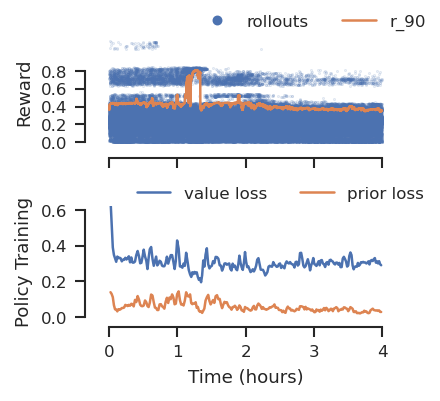

174980 games loaded
Reading /projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-no-cond-ion-2/policy_checkpoints/log.csv
2022-06-18 11:28:38.233276
/projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-no-cond-ion-2/viz/training-and-reward.svg


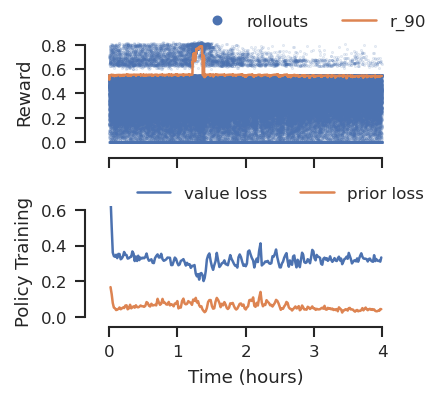

202574 games loaded
Reading /projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-no-halides-2/policy_checkpoints/log.csv
2022-06-18 11:28:31.975833
/projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-no-halides-2/viz/training-and-reward.svg


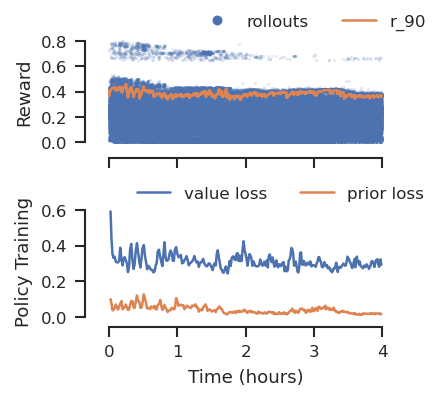

In [102]:
run_ids = ["20220617-batt-icsd-vol-r90-2",
           "20220617-batt-icsd-vol-r90-no-cond-ion-2",
           "20220617-batt-icsd-vol-r90-no-halides-2",
          ]
for run_id in run_ids:
    r_cutoff = 0.9 if 'r90' in run_id else .75
    r_rolling = 1000
    df_games = main_results(run_id, session, r_cutoff=r_cutoff, r_rolling=r_rolling)

subset to 1163 best structure per composition (out of 30924


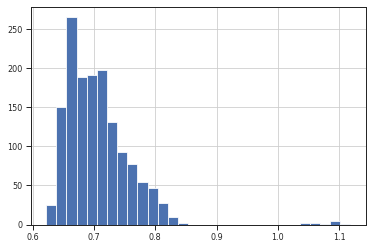

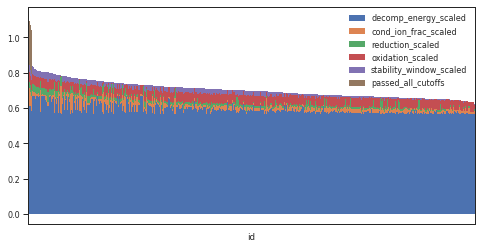

/projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-no-halides-2/viz/best_strc_per_comp_rewards.csv


In [156]:
# run_id = "20220617-batt-icsd-vol-r90-2"
# df_rew = load_rewards(session, run_id)
# df_top = apply_rew_cutoff(df_rew, rew_cutoff=.6, decomp_energy_cutoff=None)
df_top2, df_rew_scaled = plot_subrewards(df_top, out_dir=f"{log_dir}/{run_id}/viz")
# df_top2, df_rew_scaled = plot_subrewards(df_top)

  0%|          | 0/3 [00:00<?, ?it/s]

Loading rewards
here
30924 structures with reward > 0.6
59374 structures with decomp_energy < -0.1
subset to 1163 best structure per composition (out of 30924


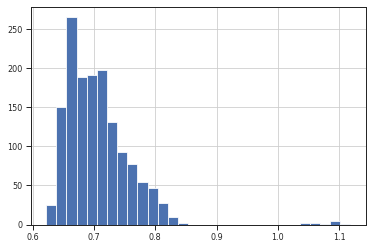

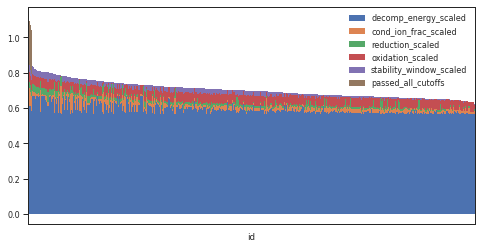

/projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-2/viz/best_strc_per_comp_rewards.csv
Loading rewards
here
29987 structures with reward > 0.6
51824 structures with decomp_energy < -0.1
subset to 1129 best structure per composition (out of 29987


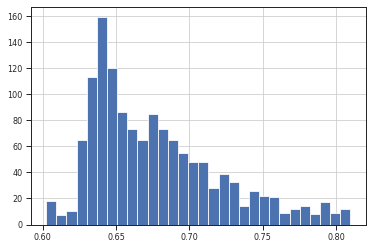

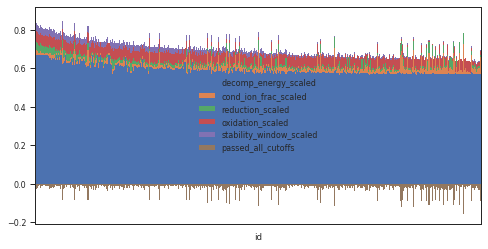

/projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-no-cond-ion-2/viz/best_strc_per_comp_rewards.csv
Loading rewards
here
1128 structures with reward > 0.6
2374 structures with decomp_energy < -0.1
subset to 149 best structure per composition (out of 1128


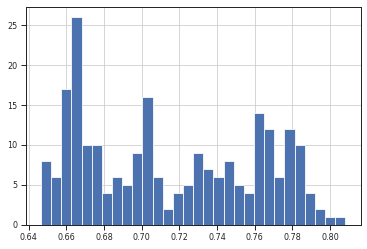

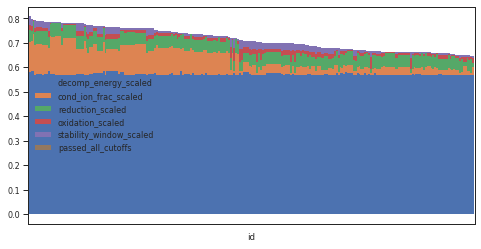

/projects/rlmolecule/jlaw/logs/crystal_energy/20220617-batt-icsd-vol-r90-no-halides-2/viz/best_strc_per_comp_rewards.csv


,id,comp,reward,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window,decomp_energy_s_w,cond_ion_frac_s_w,reduction_s_w,oxidation_s_w,stability_window_s_w,run_id
979859,Li3Sc1Br6|_1_3_6|trigonal|icsd_401335|1,Li3Sc1Br6,1.118399,-0.7607,0.3,-0.9753,-5.0000,4.0247,0.640078,0.083333,0.044719,0.055556,0.044719,20220617-batt-icsd-vol-r90-2
736942,Na3Sc1I6|_1_3_6|trigonal|icsd_401335|1,Na3Sc1I6,1.093755,-0.5759,0.3,-0.9160,-4.7555,3.8394,0.619544,0.083333,0.045378,0.052839,0.042660,20220617-batt-icsd-vol-r90-2


In [164]:
df_all = pd.DataFrame()
run_ids = ["20220617-batt-icsd-vol-r90-2",
           "20220617-batt-icsd-vol-r90-no-cond-ion-2",
           "20220617-batt-icsd-vol-r90-no-halides-2",
          ]
for run_id in tqdm(run_ids):
    r_cutoff = 0.9 if 'r90' in run_id else .75
    r_rolling = 1000
    df_rew = load_rewards(session, run_id)
    df_top = apply_rew_cutoff(df_rew, rew_cutoff=.6, decomp_energy_cutoff=None)
    df_top2, df_rew_scaled = plot_subrewards(df_top, out_dir=f"{log_dir}/{run_id}/viz")
    df_top2['run_id'] = run_id
    df_all = pd.concat([df_all, df_top2])
# df_all.reset_index(drop=True, inplace=True)
df_all.head(2)

  0%|          | 0/3 [00:00<?, ?it/s]

Loading rewards
Loading rewards
Loading rewards


,digest,hash,run_id,time,reward,data
769644,fe71ef56a63518b66b7b62c5897640db4bbce57c17b979...,3602953639443413874,20220617-batt-icsd-vol-r90-2,2022-06-18 11:58:24.400575,1.135173,"{'terminal': True, 'num_sites': 20, 'volume': ..."
7892,69a4796f7b3d381c4d7227b6e7c21db270fceb55a6da5a...,4318079982642912558,20220617-batt-icsd-vol-r90-2,2022-06-18 11:28:58.399816,1.132112,"{'terminal': True, 'num_sites': 12, 'volume': ..."


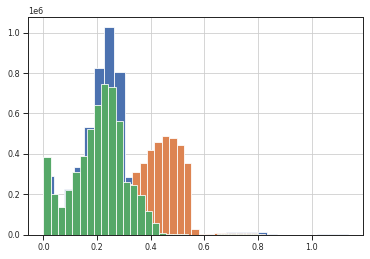

In [214]:
df_all2 = pd.DataFrame()
run_ids = ["20220617-batt-icsd-vol-r90-2",
           "20220617-batt-icsd-vol-r90-no-cond-ion-2",
           "20220617-batt-icsd-vol-r90-no-halides-2",
          ]
for run_id in tqdm(run_ids):
    r_cutoff = 0.9 if 'r90' in run_id else .75
    r_rolling = 1000
    df_rew = load_rewards(session, run_id)
    df_rew.reward.hist(bins=30)
    # df_top = apply_rew_cutoff(df_rew, rew_cutoff=.6, decomp_energy_cutoff=None)
    # df_top2, df_rew_scaled = plot_subrewards(df_top, out_dir=f"{log_dir}/{run_id}/viz")
    # df_top2['run_id'] = run_id
    df_rew['run_id'] = run_id
    df_all2 = pd.concat([df_all2, df_rew])
# df_all.reset_index(drop=True, inplace=True)
df_all2.head(2)

Text(0.5, 1.0, 'Unconstrained run (4270844 structures)')

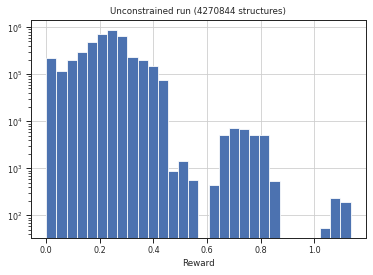

In [226]:
df2 = df_all2[df_all2.run_id == "20220617-batt-icsd-vol-r90-2"]
plt.yscale("log")
df2.reward.hist(bins=30)
plt.xlabel("Reward")
plt.title(f"Unconstrained run ({len(df2)} structures)")

Text(0.5, 1.0, 'MCTS runs (6703705 structures)')

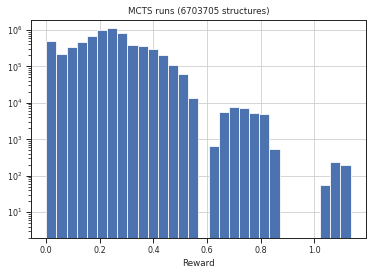

In [231]:
df_all2.reward.hist(bins=30)
plt.yscale("log")
plt.xlabel("Reward")
plt.ylim(2, plt.ylim()[1])
plt.title(f"MCTS runs ({len(df_all2)} structures)")

In [216]:
df_all2.head()

,digest,hash,run_id,time,reward,data
769644,fe71ef56a63518b66b7b62c5897640db4bbce57c17b979...,3602953639443413874,20220617-batt-icsd-vol-r90-2,2022-06-18 11:58:24.400575,1.135173,"{'terminal': True, 'num_sites': 20, 'volume': ..."
7892,69a4796f7b3d381c4d7227b6e7c21db270fceb55a6da5a...,4318079982642912558,20220617-batt-icsd-vol-r90-2,2022-06-18 11:28:58.399816,1.132112,"{'terminal': True, 'num_sites': 12, 'volume': ..."
6422,8b37bdf7c8d6d551fd0e51e21bc4573b821db26b155c95...,4318079982642912558,20220617-batt-icsd-vol-r90-2,2022-06-18 11:28:58.247067,1.132112,"{'terminal': True, 'num_sites': 12, 'volume': ..."
1065601,5539e951c684b9b0ff7d6668bfa268f0a0840812247ffc...,7030765840317826715,20220617-batt-icsd-vol-r90-2,2022-06-18 12:09:25.111300,1.132104,"{'terminal': True, 'num_sites': 20, 'volume': ..."
1082458,c750997d6596d641b00fa337f035b0f8c4d4f2bccce23d...,7030765840317826715,20220617-batt-icsd-vol-r90-2,2022-06-18 12:10:34.259839,1.132104,"{'terminal': True, 'num_sites': 20, 'volume': ..."


In [217]:
cols = ['run_id', 'time', 'reward', 'data']
df_all2[cols].to_csv("/projects/rlmolecule/jlaw/crystal_outputs/2022-06-20/batt-icsd-vol-3runs/all_decorations.csv.gz")

In [221]:
# cols = ['run_id', 'reward', 'data']
data_cols = list(df_all2.head(1).data.values[0].keys())
for c in data_cols:
    df_all2[c] = df_all2.data.apply(lambda x: x[c] if c in x else np.nan)
df_all2.head(2)

,digest,hash,run_id,time,reward,data,terminal,num_sites,volume,state_repr,predicted_energy,oxidation,reduction,stability_window,decomp_energy,cond_ion_frac
769644,fe71ef56a63518b66b7b62c5897640db4bbce57c17b979...,3602953639443413874,20220617-batt-icsd-vol-r90-2,2022-06-18 11:58:24.400575,1.135173,"{'terminal': True, 'num_sites': 20, 'volume': ...",True,20.0,350.006949,Li3Y1Br6|_1_3_6|trigonal|icsd_053533|1,-3.798492,-5.0,-0.6734,4.3266,-0.8512,0.3000
7892,69a4796f7b3d381c4d7227b6e7c21db270fceb55a6da5a...,4318079982642912558,20220617-batt-icsd-vol-r90-2,2022-06-18 11:28:58.399816,1.132112,"{'terminal': True, 'num_sites': 12, 'volume': ...",True,12.0,108.750652,Li4Y1Br7|_1_4_7|cubic|icsd_001322|1,-3.735198,-5.0,-0.6045,4.3955,-0.7266,0.3333


In [222]:
df_all2 = df_all2.drop_duplicates(subset='state_repr')

In [223]:
df_all2.rename(columns={"state_repr": "decor_id"}, inplace=True)

In [224]:
cols = ['run_id', 'decor_id', 'predicted_energy', 'decomp_energy', 'cond_ion_frac', 'oxidation', 'reduction', 'stability_window']

In [225]:
df_all2[cols].to_csv("/projects/rlmolecule/jlaw/crystal_outputs/2022-06-20/batt-icsd-vol-3runs/all_decorations2.csv.gz")

In [220]:
df_all2.head(1).data.values

array([{'terminal': True, 'num_sites': 20, 'volume': 350.0069490929776, 'state_repr': 'Li3Y1Br6|_1_3_6|trigonal|icsd_053533|1', 'predicted_energy': -3.7984917163848877, 'oxidation': -5, 'reduction': -0.6734, 'stability_window': 4.3266, 'decomp_energy': -0.8512, 'cond_ion_frac': 0.3}],
      dtype=object)

In [ ]:
df_all2 = pd.DataFrame()
run_ids = ["20220617-batt-icsd-vol-r90-2",
           "20220617-batt-icsd-vol-r90-no-cond-ion-2",
           "20220617-batt-icsd-vol-r90-no-halides-2",
          ]
for run_id in tqdm(run_ids):
    r_cutoff = 0.9 if 'r90' in run_id else .75
    r_rolling = 1000
    df_rew = load_rewards(session, run_id)
    df_rew.reward.hist(bins=30)
    # df_top = apply_rew_cutoff(df_rew, rew_cutoff=.6, decomp_energy_cutoff=None)
    # df_top2, df_rew_scaled = plot_subrewards(df_top, out_dir=f"{log_dir}/{run_id}/viz")
    # df_top2['run_id'] = run_id
    df_rew['run_id'] = run_id
    df_all2 = pd.concat([df_all2, df_rew])
# df_all.reset_index(drop=True, inplace=True)
df_all2.head(2)

  0%|          | 0/3 [00:00<?, ?it/s]

Loading rewards
Loading rewards
Loading rewards


In [166]:
df_all.groupby('run_id').id.nunique()

run_id
20220617-batt-icsd-vol-r90-2                1163
20220617-batt-icsd-vol-r90-no-cond-ion-2    1129
20220617-batt-icsd-vol-r90-no-halides-2      149
Name: id, dtype: int64

In [168]:
print(len(df_all), df_all.id.nunique())

3061 1430


In [173]:
df_all.drop_duplicates(subset='id', inplace=True)

In [206]:
def decorate_structure(decorated_str, prototypes=None, vol_pred_site_bias=None):
    # Now create the decoration of this composition onto this prototype structure
    # the 'action_node' string has the following format at this point:
    # comp_type|prototype_structure|decoration_idx
    # we just need 'comp_type|prototype_structure' to get the icsd structure
    composition = decorated_str.split('|')[0]
    structure_key = '|'.join(decorated_str.split('|')[1:-1])
    icsd_prototype = prototypes[structure_key]
    decoration_idx = int(decorated_str.split('|')[-1]) - 1
    # print(decorated_str, composition, structure_key)
    try:
        decorated_structure, comp = CrystalState.decorate_prototype_structure(
            icsd_prototype, composition, decoration_idx=decoration_idx)
        # also predict the volume
        if vol_pred_site_bias is not None:
            decorated_structure = scale_by_pred_vol(decorated_structure, 
                                                    vol_pred_site_bias,
                                                    dls_vol_predictor,
                                                   )
        #decorations[descriptor] = decorated_structure.as_dict()
    except AssertionError as e:
        print(f"AssertionError: {e}")
        return
        #volume_stats[descriptor] = (-1, -1, 0, comp_type)
        #return 0.0, {'terminal': True, 'state_repr': repr(state)}
    
    return decorated_structure

In [175]:
def extract_id(decorated_str):
    decor_split = decorated_str.split('|')
    out_str = '_'.join([decor_split[0], decor_split[3].replace('POSCAR_',''), decor_split[4]])
    return out_str

In [176]:
def write_structure(row, out_dir):
    out_file = f"{out_dir}/best_decorations/POSCAR_{row.id}"
    row.structure.to(filename=out_file)

In [183]:
df_all.head(2)

,decor_id,comp,reward,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window,decomp_energy_s_w,cond_ion_frac_s_w,reduction_s_w,oxidation_s_w,stability_window_s_w,run_id,id
979859,Li3Sc1Br6|_1_3_6|trigonal|icsd_401335|1,Li3Sc1Br6,1.118399,-0.7607,0.3,-0.9753,-5.0000,4.0247,0.640078,0.083333,0.044719,0.055556,0.044719,20220617-batt-icsd-vol-r90-2,Li3Sc1Br6_icsd_401335_1
736942,Na3Sc1I6|_1_3_6|trigonal|icsd_401335|1,Na3Sc1I6,1.093755,-0.5759,0.3,-0.9160,-4.7555,3.8394,0.619544,0.083333,0.045378,0.052839,0.042660,20220617-batt-icsd-vol-r90-2,Na3Sc1I6_icsd_401335_1


In [207]:
out_dir = "/projects/rlmolecule/jlaw/crystal_outputs/2022-06-20/batt-icsd-vol-3runs"
os.makedirs(out_dir, exist_ok=True)
# df_all.rename(columns={'id': 'decor_id'}, inplace=True)
# df_all['id'] = df_all.decor_id.apply(extract_id)
# df_all = df_all.loc[df_all.groupby('comp')['reward'].idxmax().values]
df_all['structure'] = df_all.decor_id.progress_apply(decorate_structure,
                                                     prototypes=proto_structures,
                                                     # vol_pred_site_bias=site_bias,
                                                     )
# df_all['volume'] = df_all.structure.apply(lambda x: x.volume)
# df_all['dls_volume'] = df_all.structure.apply(lambda x: x.volume)
df_all.to_pickle(f"{out_dir}/best_decorations.p")
col_order = ["run_id", "id"] + list(df_all.columns)[:-2]
df_all.drop('structure', axis=1)[col_order].to_csv(f"{out_dir}/best_decorations.csv", index=False)

os.makedirs(f"{out_dir}/best_decorations", exist_ok=True)
df_all.progress_apply(write_structure, out_dir=out_dir, axis=1)

  0%|          | 0/1430 [00:00<?, ?it/s]

  0%|          | 0/1430 [00:00<?, ?it/s]

979859     None
736942     None
13618      None
90592      None
575973     None
           ... 
3924990    None
3822280    None
2345768    None
3647235    None
663541     None
Length: 1430, dtype: object

## Backup

<AxesSubplot:>

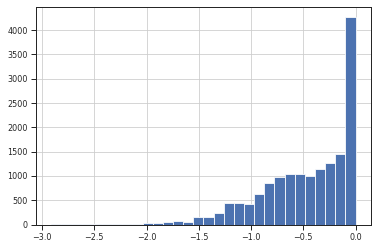

In [38]:
df_top = df_rew[df_rew.reward > 0.5]
df_top.decomp_energy.hist(bins=30)

In [150]:
from rlmolecule.crystal import crystal_reward
from importlib import reload  # Python 3.4+
crystal_reward = reload(crystal_reward)
rew_combiner = crystal_reward.StructureRewardBattInterface(None)

In [45]:
import pandas as pd
pd.options.mode.chained_assignment = None

In [46]:
# rew_combiner = StructureRewardBattInterface(None)
df_top['scaled_rew'] = df_top.sub_rewards.apply(
    lambda x: rew_combiner.combine_rewards(x, return_weighted=True))
for col in rew_cols:
    df_top.loc[:, col+'_scaled'] = df_top.scaled_rew.apply(lambda x: x[col])
df_top.head(2)

,digest,hash,run_id,time,reward,data,time_hours,id,terminal,num_sites,...,stability_window,decomp_energy,cond_ion_frac,sub_rewards,scaled_rew,decomp_energy_scaled,cond_ion_frac_scaled,reduction_scaled,oxidation_scaled,stability_window_scaled
500405,a1b116e6d4c60ca56d340de6555b32a3af5da380e31862...,1959810201582887609,20220617-batt-icsd-vol-buff250-2,2022-06-17 03:14:05.514542,0.831655,"{'terminal': True, 'num_sites': 16, 'volume': ...",0.292537,Li4F1Cl3|_1_3_4|orthorhombic|icsd_075927|1,True,16.0,...,4.0586,-0.0011,0.5,"{'decomp_energy': -0.0011, 'cond_ion_frac': 0....","{'decomp_energy': 0.41675833333333334, 'cond_i...",0.416758,0.24,0.066667,0.054115,0.054115
1437519,8944eb55a2db91208eff059d6d62dabdeb31af9c04569a...,8520073910079365568,20220617-batt-icsd-vol-buff250-2,2022-06-17 03:49:15.176756,0.826229,"{'terminal': True, 'num_sites': 20, 'volume': ...",0.878554,Li3I1S1|_1_1_3|cubic|icsd_077333|2,True,20.0,...,2.3462,-0.0142,0.6,"{'decomp_energy': -0.0142, 'cond_ion_frac': 0....","{'decomp_energy': 0.41785, 'cond_ion_frac': 0....",0.417850,0.30,0.066667,0.010428,0.031283


In [47]:
df_rew_scaled = df_top[[c+'_scaled' for c in rew_cols] + ['id']].set_index('id')

In [48]:
df_rew_scaled.head(2)

,decomp_energy_scaled,cond_ion_frac_scaled,reduction_scaled,oxidation_scaled,stability_window_scaled
id,,,,,
Li4F1Cl3|_1_3_4|orthorhombic|icsd_075927|1,0.416758,0.24,0.066667,0.054115,0.054115
Li3I1S1|_1_1_3|cubic|icsd_077333|2,0.417850,0.30,0.066667,0.010428,0.031283


<AxesSubplot:>

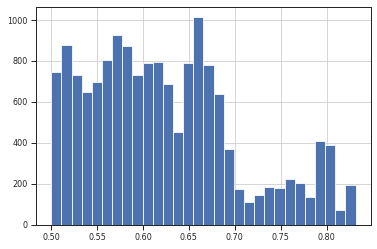

In [50]:
df_rew_scaled.sum(axis=1).hist(bins=30)

[]

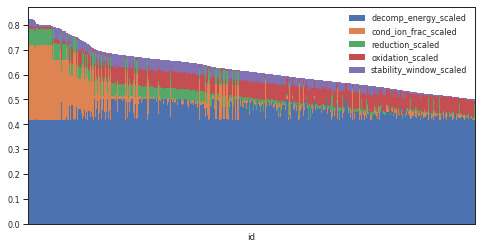

In [51]:
f, ax = plt.subplots(figsize=(8,4))
ax = df_rew_scaled.plot(kind='bar', stacked=True, 
                        width=1.0, linewidth=0, 
                        ax=ax)
ax.set_xticks([])


[]

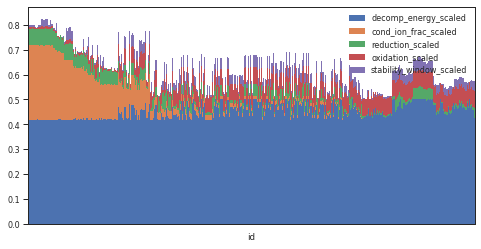

In [52]:
f, ax = plt.subplots(figsize=(8,4))
ax = df_rew_scaled.sort_values('cond_ion_frac_scaled', ascending=False).plot(kind='bar', stacked=True, 
                        width=1.0, linewidth=0, 
                        ax=ax)
ax.set_xticks([])


In [237]:
# also see how many structures have the desired cond ion fraction
df_top2 = df_rew[(df_rew.decomp_energy < 0.05) & (df_rew.cond_ion_frac >= .3)]
len(df_top2)

662

In [ ]:
rew_combiner = StructureRewardBattInterface(None)
rew_cols = ['decomp_energy', "cond_ion_frac", "cond_ion_vol_frac", "reduction", "oxidation", "stability_window"]
df_top2['sub_rewards'] = df_top2.apply(lambda row: {c: row[c] for c in rew_cols}, axis=1)
df_top2['scaled_rew'] = df_top2.sub_rewards.apply(lambda x: get_scaled_rewards(rew_combiner, x))
for col in rew_cols:
    df_top2.loc[:, col+'_scaled'] = df_top2.scaled_rew.apply(lambda x: x[col])
df_top2.head(2)

,digest,hash,run_id,time,reward,data,time_hours,id,terminal,num_sites,...,cond_ion_frac,cond_ion_vol_frac,sub_rewards,scaled_rew,decomp_energy_scaled,cond_ion_frac_scaled,cond_ion_vol_frac_scaled,reduction_scaled,oxidation_scaled,stability_window_scaled
32668,30293fb8ee5a46e0bcbfa8deda359f2b338fd08f249915...,2131766609857592968,20220613-batt-icsd-vol-predvol-2,2022-06-15 05:09:17.363730,0.805569,"{'terminal': True, 'num_sites': 20, 'volume': ...",0.266961,Li3Sc1Br6|_1_3_6|trigonal|icsd_401335|1,True,20.0,...,0.3,0.275327,"{'decomp_energy': -0.7265536122772214, 'cond_i...","{'decomp_energy': 0.4772128010231018, 'cond_io...",0.477213,0.0375,0.034416,0.07822,0.1,0.07822
33457,15a085b73f3147a6d63236f6e63c156518763014a6a092...,5539738278395395481,20220613-batt-icsd-vol-predvol-2,2022-06-15 05:09:21.808953,0.804914,"{'terminal': True, 'num_sites': 20, 'volume': ...",0.268196,Li3Sc1Br6|_1_3_6|hexagonal|icsd_626392|1,True,20.0,...,0.3,0.264633,"{'decomp_energy': -0.7297014527770993, 'cond_i...","{'decomp_energy': 0.4774751210647583, 'cond_io...",0.477475,0.0375,0.033079,0.07843,0.1,0.07843


In [ ]:
df_rew_scaled2 = df_top2[[c+'_scaled' for c in rew_cols] + ['id']].set_index('id')

[]

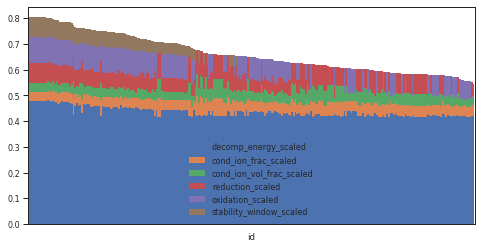

In [ ]:
f, ax = plt.subplots(figsize=(8,4))
ax = df_rew_scaled2.plot(kind='bar', stacked=True, 
                        width=1.0, linewidth=0, 
                        ax=ax)
ax.set_xticks([])


## Backup2

In [192]:
# write all structures to the same place
out_dir = "/projects/rlmolecule/jlaw/crystal_outputs/2022-04-27-batt-icsd-vol-combined/best_decorations"
os.makedirs(out_dir, exist_ok=True)
df_all = df_all.loc[df_all.groupby('comp')['reward'].idxmax().values]
print(len(df_all))
df_all['id'] = df_all.decor_id.progress_apply(write_decorated_structure, 
                                      out_dir=out_dir, 
                                      icsd_structures=proto_structures,
                                      vol_pred_site_bias=site_bias,
                                     )
df_all['proto_id'] = df_all['id'].apply(lambda x: 'icsd_' + x.split('_')[-2])
df_all.set_index('id').to_csv(f"{out_dir}/../best_decorations.csv")
df_all.head(2)

1279


  0%|          | 0/1279 [00:00<?, ?it/s]

,decor_id,reward,pred_decomp_energy,pred_energyperatom,comp,id,proto_id
47167,K1B1Cl4|_1_1_4|orthorhombic|POSCAR_sg31_icsd_0...,2.469,-2.469,-6.294676,K1B1Cl4,K1B1Cl4_sg31_icsd_065882_1,icsd_065882
47121,K1B1Ge1Cl5N1|_1_1_1_1_5|tetragonal|POSCAR_sg12...,2.921,-2.921,-7.483702,K1B1Ge1Cl5N1,K1B1Ge1Cl5N1_sg129_icsd_420040_2,icsd_420040


In [28]:
def test(x):
    return 1,2,3
df2 = df.head()
df2[['a', 'b', 'c']] = df2.apply(test, axis=1, result_type='expand')
df2

/lustre/eaglefs/projects/rlmolecule/jlaw/envs/crystals_nfp0_3/lib/python3.8/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,decor_id,reward,pred_decomp_energy,pred_energyperatom,comp,a,b,c
0,K1Ge2Cl6N1|_1_1_2_6|cubic|POSCAR_sg225_icsd_03...,3.799,-3.799,-7.755982,K1Ge2Cl6N1,1,2,3
1,K1B2Cl7|_1_2_7|cubic|POSCAR_sg205_icsd_024854|1,3.033,-3.033,-6.938518,K1B2Cl7,1,2,3
2,K1B2Cl7|_1_2_7|tetragonal|POSCAR_sg141_icsd_02...,3.003,-3.003,-6.908506,K1B2Cl7,1,2,3
3,K1Ge2Cl6N1|_1_1_2_6|orthorhombic|POSCAR_sg62_i...,2.921,-2.921,-6.877828,K1Ge2Cl6N1,1,2,3
4,K1B2Cl7|_1_2_7|hexagonal|POSCAR_sg173_icsd_075...,2.743,-2.743,-6.648516,K1B2Cl7,1,2,3


In [192]:
# write structures to a 
out_dir = "/projects/rlmolecule/jlaw/crystal_outputs/2022-04-27-batt-icsd-vol-combined/best_decorations"
os.makedirs(out_dir, exist_ok=True)
df_all = df_all.loc[df_all.groupby('comp')['reward'].idxmax().values]
print(len(df_all))
df_all['id'] = df_all.decor_id.progress_apply(write_decorated_structure, 
                                      out_dir=out_dir, 
                                      icsd_structures=proto_structures,
                                      vol_pred_site_bias=site_bias,
                                     )
df_all['proto_id'] = df_all['id'].apply(lambda x: 'icsd_' + x.split('_')[-2])
df_all.set_index('id').to_csv(f"{out_dir}/../best_decorations.csv")
df_all.head(2)

1279


  0%|          | 0/1279 [00:00<?, ?it/s]

,decor_id,reward,pred_decomp_energy,pred_energyperatom,comp,id,proto_id
47167,K1B1Cl4|_1_1_4|orthorhombic|POSCAR_sg31_icsd_0...,2.469,-2.469,-6.294676,K1B1Cl4,K1B1Cl4_sg31_icsd_065882_1,icsd_065882
47121,K1B1Ge1Cl5N1|_1_1_1_1_5|tetragonal|POSCAR_sg12...,2.921,-2.921,-7.483702,K1B1Ge1Cl5N1,K1B1Ge1Cl5N1_sg129_icsd_420040_2,icsd_420040


In [147]:
df_all.proto_id.value_counts()

icsd_071581    74
icsd_066994    17
icsd_407646    13
icsd_202422    12
icsd_034944    12
               ..
icsd_419918     1
icsd_002763     1
icsd_246005     1
icsd_100477     1
icsd_409537     1
Name: proto_id, Length: 113, dtype: int64

### Compare what the predicted energy would have been for the GNN trained on volume-relaxed structures only

In [24]:
# plot the hull energy by the predicted energy
df_games.head(2)

,id,run_id,time,raw_reward,scaled_reward,search_statistics,execution_statistics,time_hours
0,11cf6b02-ee4f-489f-8318-4990c8cfbb85,20220422-batt-icsd-vol-norm-2,2022-04-23 07:48:45.882994,0.067,0.0,[[4f27ce5de30b5dbb727c1b2601211b1e7a7bc4b1ceb3...,"{'total_time': 8.640500783920288, 'execution_t...",0.000000
1,d09ba621-c763-4504-a393-1665f56a9669,20220422-batt-icsd-vol-norm-2,2022-04-23 07:48:45.893185,0.263,1.0,[[4f27ce5de30b5dbb727c1b2601211b1e7a7bc4b1ceb3...,"{'total_time': 8.583186388015747, 'execution_t...",0.000003


In [25]:
df_rew.head(2)

,digest,hash,run_id,time,reward,data
122061,36d22a812d52708cc535666c806a40237bc7f26f9f846f...,8394969624402074818,20220422-batt-icsd-vol-norm-2,2022-04-23 08:30:31.061436,5.555,"{'terminal': True, 'predicted_energy': -8.6870..."
292165,d484257b1d92e7b86f00472a2cb39297428d6e02e51d5f...,440404501447798281,20220422-batt-icsd-vol-norm-2,2022-04-23 09:22:40.840474,5.533,"{'terminal': True, 'predicted_energy': -8.5820..."


In [26]:
len(df_rew)

677439

In [177]:
# compare the decorations common for different runs
stats = {}
df_all = pd.DataFrame()
rew_cutoff = 2
for run_id in [
    # "20220422-batt-icsd-vol-2-Li",
    "20220422-batt-icsd-volpred-Li",
    "20220422-batt-icsd-volpred-Li-debug",
    ]:
    df_rew = load_rewards(session, run_id)
    print(f"{run_id}: {len(df_rew)} rewards")
    # df_games, df_rew = main_results(run_id, session)
    top_rew = df_rew[df_rew['reward'] > rew_cutoff]
    best_crystal_states = {}
    for rew, data in top_rew[['reward', 'data']].values:
        best_crystal_states[data['state_repr']] = (
            rew, data['hull_energy'], 
            data['predicted_energy'])
    best_crys_comp = [s.split('|')[0] for s in best_crystal_states]
    S = pd.Series(list(best_crys_comp))
    comp_counts = S.value_counts()

    num_decors = df_rew[df_rew['reward'] > rew_cutoff]['data'].apply(lambda x: x['state_repr']).nunique()
    print(f"{run_id}: {num_decors} decorations, {len(comp_counts)} compositions")
    stats[run_id] = (len(best_crystal_states), len(comp_counts))
    
    df = pd.DataFrame(best_crystal_states).T.reset_index()
    df.columns = ['decor_id', 'reward', 'pred_decomp_energy', 'pred_energyperatom']
    df['comp'] = df.decor_id.apply(lambda x: x.split('|')[0])
    df['run_id'] = run_id
    df_all = pd.concat([df_all, df])
df_all.reset_index(drop=True, inplace=True)
df_all.head(2)

20220422-batt-icsd-volpred-Li: 127576 rewards
20220422-batt-icsd-volpred-Li: 2892 decorations, 182 compositions
20220422-batt-icsd-volpred-Li-debug: 58348 rewards
20220422-batt-icsd-volpred-Li-debug: 1596 decorations, 118 compositions


,decor_id,reward,pred_decomp_energy,pred_energyperatom,comp,run_id
0,Li2Ge1F1Cl5|_1_1_2_5|hexagonal|POSCAR_sg194_ic...,3.945,-3.945,-7.688665,Li2Ge1F1Cl5,20220422-batt-icsd-volpred-Li
1,Li2Ge1F1Cl5|_1_1_2_5|hexagonal|POSCAR_sg194_ic...,3.883,-3.883,-7.627611,Li2Ge1F1Cl5,20220422-batt-icsd-volpred-Li


In [178]:
states1 = set(df_all[df_all.run_id == "20220422-batt-icsd-volpred-Li"].decor_id)
states2 = set(df_all[df_all.run_id == "20220422-batt-icsd-volpred-Li-debug"].decor_id)
print(len(states1 & states2))
states1 = set(df_all[df_all.run_id == "20220422-batt-icsd-volpred-Li"].comp)
states2 = set(df_all[df_all.run_id == "20220422-batt-icsd-volpred-Li-debug"].comp)
print(len(states1 & states2))

1204
89
